# Fake News Detection

### Import statements

In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

### Read the data
The data consists of fake and true files seperately. The two are combined into a single dataset and the target feature label is created: 0 for fake and 1 for real.

In [2]:
fake_data = pd.read_csv(r"Fake.csv")
fake_data["label"] = 0
real_data = pd.read_csv(r"True.csv")
real_data["label"] = 1

In [3]:
data = pd.concat([fake_data, real_data])
#data is shuffled to mix the label feature
data = shuffle(data)
data.head()

,title,text,subject,date,label
22113,Washington’s Criminal Activities Are Only Gett...,21st Century Wire says It was a major scandal ...,US_News,"May 9, 2017",0
4925,GOP Lobbyist Takes A COMPLETELY Unexpected St...,A GOP lobbyist who s known for his own brand o...,News,"August 23, 2016",0
19114,"LEFTIST MEDIA DESTROYED Mike Flynn, Cracked Jo...",Fun fact: While Trump press secretary Sean Spi...,left-news,"Feb 20, 2017",0
20331,U.S. officials say about 5-6 million customers...,WASHINGTON (Reuters) - Five million to 6 milli...,worldnews,"September 12, 2017",1
18640,PRESIDENT TRUMP WARNS Comey…Tweets Veiled Thre...,Donald Trump lobbed a veiled threat at the for...,left-news,"May 12, 2017",0


In [4]:
data.reset_index(level=0, inplace=True)

In [5]:
data.drop(["index"],axis = 1,inplace = True)

In [6]:
data.head()

,title,text,subject,date,label
0,Washington’s Criminal Activities Are Only Gett...,21st Century Wire says It was a major scandal ...,US_News,"May 9, 2017",0
1,GOP Lobbyist Takes A COMPLETELY Unexpected St...,A GOP lobbyist who s known for his own brand o...,News,"August 23, 2016",0
2,"LEFTIST MEDIA DESTROYED Mike Flynn, Cracked Jo...",Fun fact: While Trump press secretary Sean Spi...,left-news,"Feb 20, 2017",0
3,U.S. officials say about 5-6 million customers...,WASHINGTON (Reuters) - Five million to 6 milli...,worldnews,"September 12, 2017",1
4,PRESIDENT TRUMP WARNS Comey…Tweets Veiled Thre...,Donald Trump lobbed a veiled threat at the for...,left-news,"May 12, 2017",0


### Check for missing values

In [7]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

### Text preprocessing

In [8]:
#stopwords from nltk library to be removed from the data
stopword = stopwords.words('english')

In [9]:
def text_processing(text):
    #remove punctuations
    text = re.sub("[^\w\d\s]+",' ',text)
    #lower case the words
    text = text.lower()
    #convert the sentences to tokens
    tok = nltk.word_tokenize(text)
    #remove stopwords
    words = [word for word in tok if word not in stopword]
    return words

In [10]:
#join the words into the data
def join_words(words):
    words = ' '.join(words)
    return words

In [11]:
#perform text processing on the data using the above defined functions
for i in data:
    if i == "label":
        continue
    else:
        data[i] = data[i].apply(lambda x: text_processing(x))

In [12]:
for j in data:
    if j == "label":
        continue
    else:
        data[j] = data[j].apply(lambda x: join_words(x))

In [13]:
data.head()

,title,text,subject,date,label
0,washington criminal activities getting messier,21st century wire says major scandal broke 200...,us_news,may 9 2017,0
1,gop lobbyist takes completely unexpected step ...,gop lobbyist known brand bigotry denounced tru...,news,august 23 2016,0
2,leftist media destroyed mike flynn cracked jok...,fun fact trump press secretary sean spicer fie...,left news,feb 20 2017,0
3,u officials say 5 6 million customers without ...,washington reuters five million 6 million powe...,worldnews,september 12 2017,1
4,president trump warns comey tweets veiled thre...,donald trump lobbed veiled threat former fbi d...,left news,may 12 2017,0


## Data exploration
reference: #https://www.kaggle.com/benfraser/visually-exploring-and-predicting-fake-news

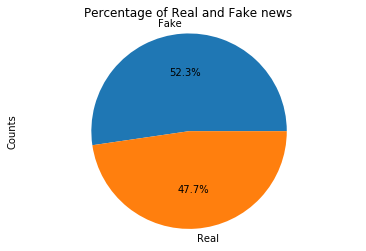

In [14]:
#Plot the percentage of fake and real news in the data
real = len(data[data["label"] == 1])
fake = len(data[data["label"] == 0])

df_count_pie = pd.DataFrame({'Class' : ['Real', 'Fake'], 
                             'Counts' : [real, fake]})
df_count_pie.Counts.groupby(df_count_pie.Class).sum().plot(kind='pie',autopct = '%1.1f%%')
plt.axis('equal')
plt.title("Percentage of Real and Fake news")
plt.show()

Text(0.5,1,'Subject wise total real and fake news')

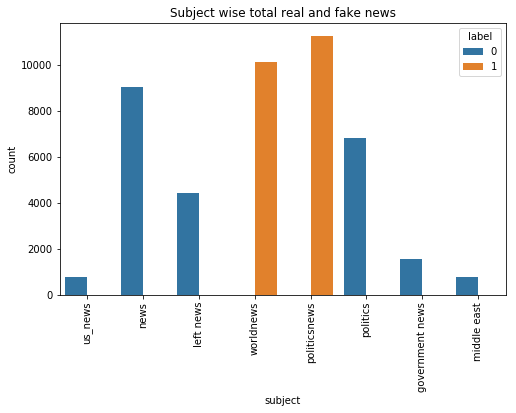

In [15]:
#Visualize the count of fake and real news based on Subject topics
plt.figure(figsize=(8,5))
ax = sns.countplot(x = "subject", hue = "label", data = data)
plt.xticks(rotation=90)
plt.title("Subject wise total real and fake news")

In [16]:
#create a corpus of words
def create_corpus(text_data):
    corpus = []
    for sentence in text_data:
        for word in sentence.split():
            corpus.append(word)
    return corpus

#pick the top words
def top_words(text_corpus, top_n=25, return_dict=False):
    def_dict = defaultdict(int)
    for word in text_corpus:
        def_dict[word] += 1
    most_common = sorted(def_dict.items(), key=lambda x : x[1], reverse=True)[:top_n]
    if return_dict:
        return most_common, def_dict
    else:    
        return most_common

#plot the words
def plot_words(word_list, word_counts, n, text_description, figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.xticks(rotation=90)
    plt.bar(word_list, word_counts)
    plt.title(f"Top {n} words in {text_description}", weight='bold')
    plt.ylabel("Word Count", weight='bold')
    plt.show()

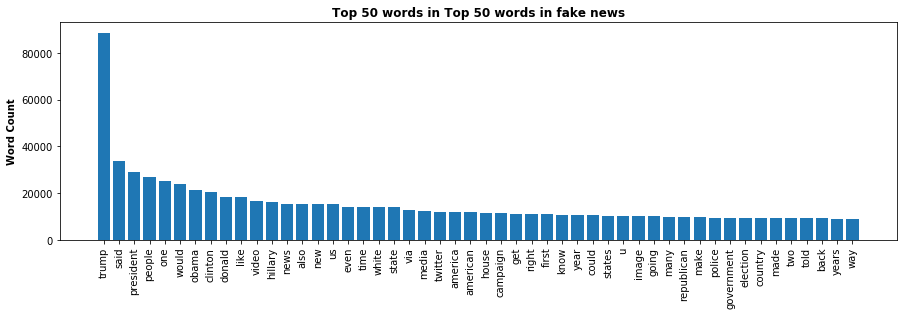

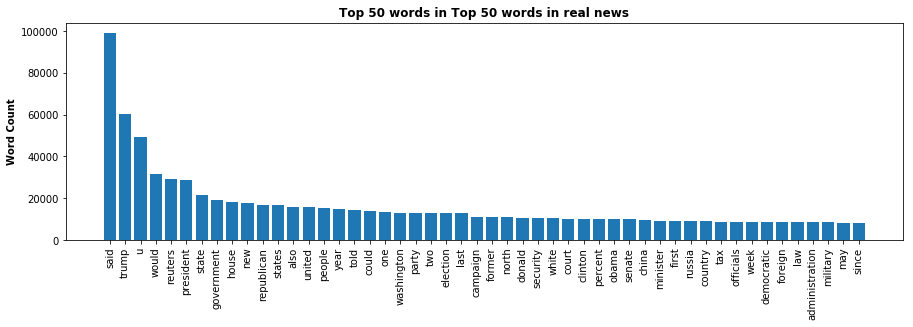

In [17]:
#plot the top 50 words count in the fake and real news
top_n = 50
data["news"] = data["title"] + " " + data["text"]
text_field = "news"

fake_news = data.loc[data['label'] == 0]
true_news = data.loc[data['label'] == 1]

fake_corpus = create_corpus(fake_news[text_field].values)
fake_top_n_words, fake_symptom_dict = top_words(fake_corpus, top_n = top_n, return_dict = True)
fake_words, fake_word_counts = zip(*fake_top_n_words)
plot_words(fake_words, fake_word_counts, 50, "Top 50 words in fake news", figsize=(15,4))

true_corpus = create_corpus(true_news[text_field].values)
true_top_n_words, true_symptom_dict = top_words(true_corpus, top_n=top_n, return_dict=True)
true_words, true_word_counts = zip(*true_top_n_words)
plot_words(true_words, true_word_counts, 50, "Top 50 words in real news", figsize=(15,4))

## Preparing data for models

In [18]:
#Prepare the data using title
X_title = data.title
y_title = data.label

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_title,y_title, test_size = 0.33, random_state = 42)

In [20]:
#use TF=IDF to convert the words to vectors
tvec = TfidfVectorizer(min_df = 2, max_df = 0.90, max_features = 1000)
word_vec = tvec.fit(X_train)

In [21]:
#convert the transform to dataframe
train_df = pd.DataFrame(tvec.transform(X_train).todense(),columns = tvec.get_feature_names())

In [22]:
train_df.head()

,000,10,100,11,12,13,15,20,2016,2018,...,wrong,xi,year,years,yemen,yet,york,young,yr,zimbabwe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515488,0.0


In [23]:
test_df = pd.DataFrame(tvec.transform(X_test).todense(),columns = tvec.get_feature_names())

In [24]:
test_df.head()

,000,10,100,11,12,13,15,20,2016,2018,...,wrong,xi,year,years,yemen,yet,york,young,yr,zimbabwe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#Prepare the data using text
X_text = data.text
y_text = data.label

In [26]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_text,y_text, test_size = 0.33, random_state = 42)

In [27]:
tvec = TfidfVectorizer(min_df = 2, max_df = 0.90, max_features = 4000)
tvec.fit(X_train1)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=4000,
                min_df=2, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [28]:
#convert the transform to dataframe
train_df1 = pd.DataFrame(tvec.transform(X_train1).todense(),columns = tvec.get_feature_names())

In [29]:
test_df1 = pd.DataFrame(tvec.transform(X_test1).todense(),columns = tvec.get_feature_names())

In [30]:
#concatanate the text and title df
train = pd.concat([train_df,train_df1],axis = 1)
test = pd.concat([test_df,test_df1],axis = 1)

In [31]:
train.head()

,000,10,100,11,12,13,15,20,2016,2018,...,youtu,youtube,zealand,zero,zika,zimbabwe,zone,zones,zor,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.060358,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.062209,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [32]:
test.head()

,000,10,100,11,12,13,15,20,2016,2018,...,youtu,youtube,zealand,zero,zika,zimbabwe,zone,zones,zor,zuma
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
from sklearn.feature_selection.univariate_selection import SelectKBest, chi2, f_classif
fselect = SelectKBest(chi2 , k = 1000)
train_features = fselect.fit_transform(train, y_train1)
test_features = fselect.transform(test)

/Users/shravika/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.univariate_selection module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [34]:
#remove duplicate features
train = train.loc[:,~train.columns.duplicated()]

In [35]:
test = test.loc[:,~test.columns.duplicated()]

## Logistic Regression

In [36]:
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression(solver = "liblinear")
logreg_cv=GridSearchCV(logreg,grid,cv=3)
logreg_cv.fit(train,y_train)

In [ ]:
logreg_cv.cv_results_

In [75]:
clf = LogisticRegression(C = 0.0015,random_state = 0,solver='liblinear', penalty='l2')
clf.fit(train,y_train1)

LogisticRegression(C=0.0015, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
#predict for test values
lr_pred = clf.predict(test)

In [77]:
#accuracy score
#accuracy_score(lr_pred,y_test)
print("The accuracy score for Logistic Regression Model is", round(accuracy_score(lr_pred,y_test)*100,2))

The accuracy score for Logistic Regression Model is 84.68


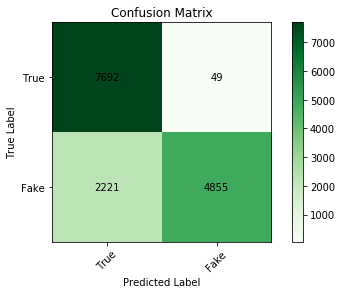

In [102]:
#confusion matrix
lr_res = confusion_matrix(y_test, lr_pred)
plot_confusion_matrix(lr_res, ['True','Fake'])

## XGBoost Classifier

In [ ]:
conda install -c conda-forge xgboost

In [78]:
xgb_model = XGBClassifier(learning_rate = 0.01,gamma = 10)
xgb_model.fit(train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [79]:
xgb_pred = xgb_model.predict(test)

In [83]:
accuracy_score(xgb_pred,y_test)
print("The accuracy score for Proposed XGBoost Model is", round(accuracy_score(xgb_pred,y_test)*100,2))

The accuracy score for Proposed XGBoost Model is 92.87


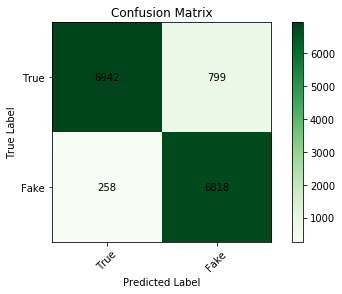

In [84]:
xg_res = confusion_matrix(y_test, xgb_pred)
plot_confusion_matrix(xg_res, ['True','Fake'])

## CNN
CNN model is built on the text and title feature. 

In [ ]:
conda install -c conda-forge keras

In [86]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
import keras

X_news = data["title"] + " " + data["text"]
y_news = data["label"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_news,y_news, test_size = 0.33, random_state = 42)

#tokenize the text data
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X_train2)

X_train_cnn = tokenizer.texts_to_sequences(X_train2)
X_test_cnn = tokenizer.texts_to_sequences(X_test2)

#create a vocabulary size based on the word index created using tokenizer
vocab_size = len(tokenizer.word_index) + 1 

Using TensorFlow backend.
/Users/shravika/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/shravika/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/shravika/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/shravika/anaconda3/lib/python3.7/site-pa

In [87]:
#max length takes only sentences less than 50
maxlen = 50

#Pad the sentences in X_train_cnn and X_test_cnn so that all data values are of same length
X_train_cnn = pad_sequences(X_train_cnn, padding = 'post', maxlen = maxlen)
X_test_cnn = pad_sequences(X_test_cnn, padding = 'post', maxlen = maxlen)

In [98]:
#embedding dimension is set to 50
embedding_dim = 50
#define the optimizer with lr = 0.02
opt = keras.optimizers.Adam(learning_rate = 0.1)

#define the model layers with their filters, kernels, loss is set to binary_
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
#model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.MaxPooling1D())
#model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 50)            5165450   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 48, 128)           19328     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 20, 128)           82048     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 10, 128)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 4, 128)            114816    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)              

In [100]:
#train the model for 10 epochs, batch size of 32
model_train = model.fit(X_train_cnn, y_train2,
                    epochs = 10,
                    verbose = True,
                    validation_data=(X_test_cnn, y_test2),
                    batch_size = 128)

Train on 30081 samples, validate on 14817 samples
Epoch 1/10
30081/30081 [==============================] - 21s 711us/step - loss: 7.8229 - accuracy: 0.5138 - val_loss: 7.6974 - val_accuracy: 0.5224
Epoch 2/10
30081/30081 [==============================] - 21s 705us/step - loss: 7.7608 - accuracy: 0.5177 - val_loss: 7.6974 - val_accuracy: 0.5224
Epoch 3/10
30081/30081 [==============================] - 21s 707us/step - loss: 7.7903 - accuracy: 0.5159 - val_loss: 7.6974 - val_accuracy: 0.5224
Epoch 4/10
30081/30081 [==============================] - 21s 714us/step - loss: 7.8160 - accuracy: 0.5143 - val_loss: 7.6974 - val_accuracy: 0.5224
Epoch 5/10
30081/30081 [==============================] - 21s 714us/step - loss: 7.8346 - accuracy: 0.5131 - val_loss: 7.6974 - val_accuracy: 0.5224
Epoch 6/10
30081/30081 [==============================] - 21s 712us/step - loss: 7.7909 - accuracy: 0.5158 - val_loss: 7.6974 - val_accuracy: 0.5224
Epoch 7/10
30081/30081 [==============================] 

In [101]:
#loss and the accuracy of the model
loss, accuracy = model.evaluate(X_test_cnn, y_test2, verbose = True)
print("Testing Accuracy:  {:.4f}".format(accuracy))

14817/14817 [==============================] - 1s 75us/step
Testing Accuracy:  0.5224
